In [1]:
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *
import tensorflow as tf

from sklearn.model_selection import train_test_split
import numpy as np

## Load data

In [ ]:
dataset, info = tfds.load(
    "plant_village",
    with_info=True
)

In [3]:
info

tfds.core.DatasetInfo(
    name='plant_village',
    full_name='plant_village/1.0.2',
    description="""
    The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images
    divided into 38 categories by species and disease.
    
    NOTE: The original dataset is not available from the original source
    (plantvillage.org), therefore we get the unaugmented dataset from a paper that
    used that dataset and republished it. Moreover, we dropped images with
    Background_without_leaves label, because these were not present in the original
    dataset.
    
    Original paper URL: https://arxiv.org/abs/1511.08060 Dataset URL:
    https://data.mendeley.com/datasets/tywbtsjrjv/1
    """,
    homepage='https://arxiv.org/abs/1511.08060',
    data_path=PosixGPath('/tmp/tmp84yecy92tfds'),
    file_format=tfrecord,
    download_size=827.82 MiB,
    dataset_size=815.37 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/fi

In [4]:
info.features['label'].names[:10]

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___Powdery_mildew',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___healthy']

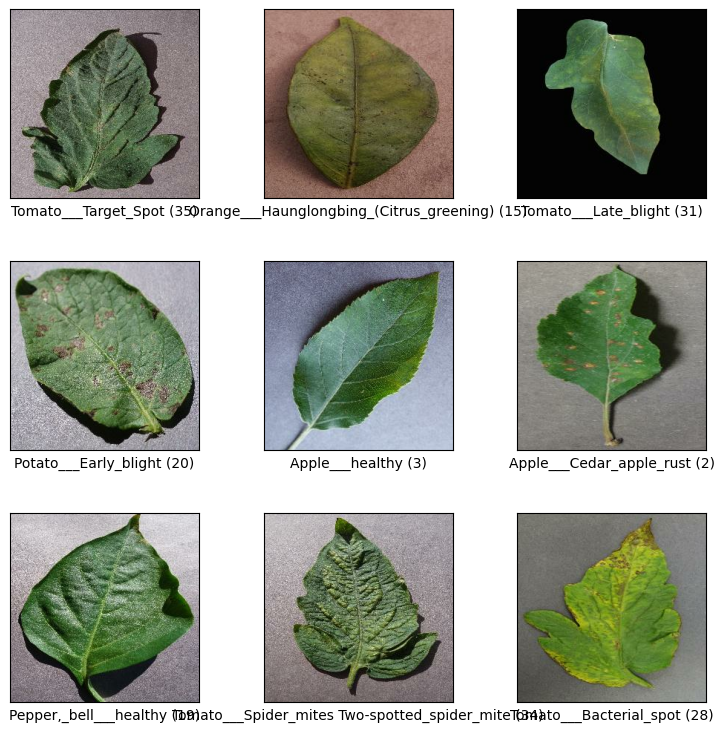

In [5]:
fig = tfds.show_examples(dataset, info)

## Image processing

In [6]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (32, 32))
    return image

In [7]:
images = []
labels = []
for i in dataset:
    images.append(preprocess(i['image'].numpy()))
    labels.append(i['label'].numpy())

images = np.array(images)
labels = np.array(labels).astype('uint32')

In [8]:
images.shape, labels.shape

((54303, 32, 32, 3), (54303,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48872, 32, 32, 3), (5431, 32, 32, 3), (48872,), (5431,))

## Build model

In [10]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(info.features['label'].num_classes, activation='softmax')
])

In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10
)

Epoch 1/10
1528/1528 [==============================] - 16s 7ms/step - loss: 1.3891 - accuracy: 0.5993 - val_loss: 0.6158 - val_accuracy: 0.8067
Epoch 2/10
1528/1528 [==============================] - 10s 7ms/step - loss: 0.6303 - accuracy: 0.8014 - val_loss: 0.4219 - val_accuracy: 0.8623
Epoch 3/10
1528/1528 [==============================] - 9s 6ms/step - loss: 0.4542 - accuracy: 0.8535 - val_loss: 0.3547 - val_accuracy: 0.8807
Epoch 4/10
1528/1528 [==============================] - 10s 7ms/step - loss: 0.3546 - accuracy: 0.8849 - val_loss: 0.2907 - val_accuracy: 0.9043
Epoch 5/10
1528/1528 [==============================] - 10s 7ms/step - loss: 0.2949 - accuracy: 0.9035 - val_loss: 0.2423 - val_accuracy: 0.9238
Epoch 6/10
1528/1528 [==============================] - 9s 6ms/step - loss: 0.2527 - accuracy: 0.9166 - val_loss: 0.2525 - val_accuracy: 0.9186
Epoch 7/10
1528/1528 [==============================] - 10s 7ms/step - loss: 0.2237 - accuracy: 0.9258 - val_loss: 0.2248 - val_accu

In [13]:
model.save("models/plant_village.h5")